<img src="../Images/DSC_Logo.png" style="width: 400px;">

# Time Series Concepts in Python 

This notebook explores foundational time series programming concepts in Python.

In [1]:
import numpy as np
import pandas as pd
import math
import statistics as stat
import random
from datetime import datetime
import xarray as xr
import py7zr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## 1. Create time series in Python

## 1.1 Python `datetime`

The datetime format in Python refers to representing and displaying dates and times. In Python's built-in `datetime` module, the `strftime` method formats `datetime` objects into readable strings based on specified format codes, e.g. `%Y`: Year with century (e.g., 2023); `%m`: Month as a zero-padded decimal (01 to 12); `%d`: Day of the month as a zero-padded decimal (01 to 31); `%H`: Hour (24-hour clock) as a zero-padded decimal (00 to 23);...

In [2]:
my_year = 2020
my_month = 1
my_day = 23
# my_hour = ...

my_date = datetime(my_year,my_month,my_day)
print(my_date)

2020-01-23 00:00:00


In [3]:
print(my_date.day)

23


Operations in datetime format:

In [4]:
nowday = datetime.today()
diff = nowday - my_date
print(diff.days)

1749


## 1.2. `datetime64` and `timedelta64` in NumPy

In [5]:
np.array(['2020-03-09','2020-03-10','2020-03-11','2020-03-12','2020-03-13','2020-03-14'], dtype='datetime64')
# or:
np.arange('2020-03-09','2020-03-15', dtype='datetime64[D]')

array(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
       '2020-03-13', '2020-03-14'], dtype='datetime64[D]')

In [6]:
# Create a timedelta of 5 days
np.timedelta64(5, 'D')

np.timedelta64(5,'D')

## 1.3. `datetime64` and `timedelta64` in Pandas

Pandas has a `DatetimeIndex` for time series data, which allows for easy indexing and slicing of dates:

In [7]:
pd.date_range('2020-03-09', periods=6, freq='D')

DatetimeIndex(['2020-03-09', '2020-03-10', '2020-03-11', '2020-03-12',
               '2020-03-13', '2020-03-14'],
              dtype='datetime64[ns]', freq='D')

Pandas utilizes `Timestamp` objects to represent specific points in time (built on top of NumPy's `datetime64` data type).  

Convert a string representation of a date into a Pandas `Timestamp` object:

In [8]:
pd.to_datetime('2020-09-03', format='%Y-%m-%d')

Timestamp('2020-09-03 00:00:00')

**Exercise:** How can the following format be converted into a DateTime object: 15/10/2020

In [9]:
pd.to_datetime('15/10/2020', format='%d/%m/%Y')

Timestamp('2020-10-15 00:00:00')

## 1.4. Create a Pandas time series dataframe

In [10]:
data = np.random.randn(6,2) # create a 2-dimensional array of random numbers
cols = ['A','B']
idx = pd.date_range('2020-03-09', periods=6, freq='D')
df = pd.DataFrame(data, index=idx, columns=cols)
print(df)

                   A         B
2020-03-09 -1.405405  0.902033
2020-03-10  1.287459  0.756675
2020-03-11  0.820324 -1.078840
2020-03-12 -0.414380 -0.365079
2020-03-13  1.467280 -1.069720
2020-03-14  1.726477 -0.850685


<Axes: >

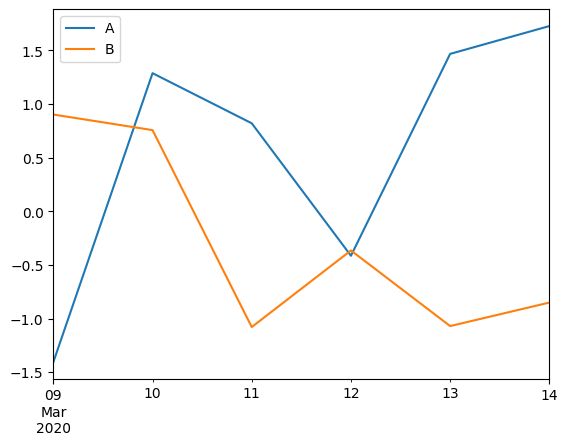

In [11]:
df.plot()

**Exercise:** Create a Pandas time series dataframe that contains decadal data and plot the time series. Refer to [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects) for a full list of frequency strings.

                   A         B
2020-12-31  0.643600 -1.474697
2021-12-31 -0.415482 -0.772652
2022-12-31 -1.080188 -0.448968
2023-12-31  0.557847 -0.224904
2024-12-31 -0.291913  0.461209
...              ...       ...
2115-12-31  1.602696  0.881143
2116-12-31  0.403461  0.577059
2117-12-31  1.262858 -0.977820
2118-12-31 -0.049153  1.347165
2119-12-31 -0.539758  0.279200

[100 rows x 2 columns]


<Axes: >

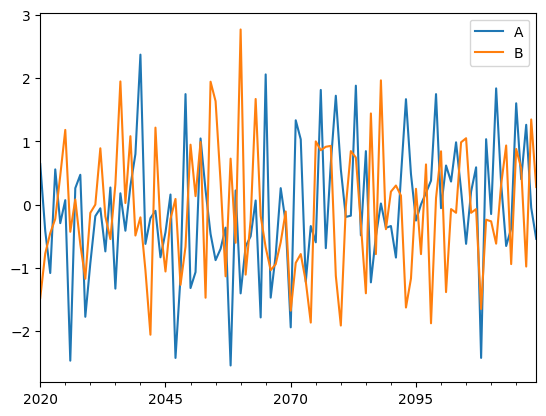

In [12]:
data = np.random.randn(100,2)
cols = ['A','B']
idx = pd.date_range('2020-03-09', periods=100, freq='YE')
df2 = pd.DataFrame(data, index=idx, columns=cols)
print(df2)
df2.plot()

## 1.5 Interchange date column and index in dataframes

Interchanging the date column and the index in DataFrames can make data easier to analyze and visualize.

In [13]:
df['Date'] = df.index
print(df)

                   A         B       Date
2020-03-09 -1.405405  0.902033 2020-03-09
2020-03-10  1.287459  0.756675 2020-03-10
2020-03-11  0.820324 -1.078840 2020-03-11
2020-03-12 -0.414380 -0.365079 2020-03-12
2020-03-13  1.467280 -1.069720 2020-03-13
2020-03-14  1.726477 -0.850685 2020-03-14


## 1.6 Derive DateTime elements

In [14]:
df['Month'] = df['Date'].dt.month
print(df)

                   A         B       Date  Month
2020-03-09 -1.405405  0.902033 2020-03-09      3
2020-03-10  1.287459  0.756675 2020-03-10      3
2020-03-11  0.820324 -1.078840 2020-03-11      3
2020-03-12 -0.414380 -0.365079 2020-03-12      3
2020-03-13  1.467280 -1.069720 2020-03-13      3
2020-03-14  1.726477 -0.850685 2020-03-14      3


In [15]:
df['Month'] = df.index.month
print(df)

                   A         B       Date  Month
2020-03-09 -1.405405  0.902033 2020-03-09      3
2020-03-10  1.287459  0.756675 2020-03-10      3
2020-03-11  0.820324 -1.078840 2020-03-11      3
2020-03-12 -0.414380 -0.365079 2020-03-12      3
2020-03-13  1.467280 -1.069720 2020-03-13      3
2020-03-14  1.726477 -0.850685 2020-03-14      3


**Exercise:** How could we define a new column with the years?

In [16]:
df['Year'] = df['Date'].dt.year
print(df)

                   A         B       Date  Month  Year
2020-03-09 -1.405405  0.902033 2020-03-09      3  2020
2020-03-10  1.287459  0.756675 2020-03-10      3  2020
2020-03-11  0.820324 -1.078840 2020-03-11      3  2020
2020-03-12 -0.414380 -0.365079 2020-03-12      3  2020
2020-03-13  1.467280 -1.069720 2020-03-13      3  2020
2020-03-14  1.726477 -0.850685 2020-03-14      3  2020


## 2. Basic time series operations

## 2.1. Aggregation - changing the frequency of time series data

In [17]:
# using resampling:
print(df.resample('W-MON').mean())

                   A         B       Date  Month    Year
2020-03-09 -1.405405  0.902033 2020-03-09    3.0  2020.0
2020-03-16  0.977432 -0.521530 2020-03-12    3.0  2020.0


In [18]:
# or using GroupBy:
df['week'] = df.index.to_period('W-MON')
print(df.groupby('week').mean())

                              A         B       Date  Month    Year
week                                                               
2020-03-03/2020-03-09 -1.405405  0.902033 2020-03-09    3.0  2020.0
2020-03-10/2020-03-16  0.977432 -0.521530 2020-03-12    3.0  2020.0


In [19]:
print(df.groupby('week').agg({'A':'mean', 'B':'sum'}))

                              A         B
week                                     
2020-03-03/2020-03-09 -1.405405  0.902033
2020-03-10/2020-03-16  0.977432 -2.607649


## 2.2 Shifting the data points in a time series forward (or backward) in time

In [20]:
df.shift(1)

,A,B,Date,Month,Year,week
2020-03-09,NaN,NaN,NaT,NaN,NaN,NaT
2020-03-10,-1.405405,0.902033,2020-03-09,3.0,2020.0,2020-03-03/2020-03-09
2020-03-11,1.287459,0.756675,2020-03-10,3.0,2020.0,2020-03-10/2020-03-16
2020-03-12,0.820324,-1.078840,2020-03-11,3.0,2020.0,2020-03-10/2020-03-16
2020-03-13,-0.414380,-0.365079,2020-03-12,3.0,2020.0,2020-03-10/2020-03-16
2020-03-14,1.467280,-1.069720,2020-03-13,3.0,2020.0,2020-03-10/2020-03-16


## 2.3 Time-based slicing

In [21]:
df['2020-03-10':'2020-03-12']
# or
df[(df['Date'] >= '2020-03-10') & (df['Date'] <= '2020-03-12')]

,A,B,Date,Month,Year,week
2020-03-10,1.287459,0.756675,2020-03-10,3,2020,2020-03-10/2020-03-16
2020-03-11,0.820324,-1.078840,2020-03-11,3,2020,2020-03-10/2020-03-16
2020-03-12,-0.414380,-0.365079,2020-03-12,3,2020,2020-03-10/2020-03-16


## 3. Import & analyze - temperature time series
![sky](../Images/temperature.jpg)

*Image modified from Gerd Altmann, Pixabay*

**Original datasets:**

NOAA National Centers for Environmental information: Climate at a Glance: Global Time Series [Data set]. https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series, retrieved on August 23, 2024.

Hersbach, H., Bell, B., Berrisford, P., Biavati, G., Horányi, A., Muñoz Sabater, J., Nicolas, J., Peubey, C., Radu, R., Rozum, I., Schepers, D., Simmons, A., Soci, C., Dee, D., Thépaut, J-N. (2023): ERA5 hourly data on single levels from 1940 to present. Copernicus Climate Change Service (C3S) Climate Data Store (CDS), DOI: 10.24381/cds.adbb2d47,      retrieved on August 27, 2024.

## 3.1. Pandas for csv files

Import data from csv:

In [22]:
path = '../Datasets/NOAA_time_series.csv' 
df = pd.read_csv(path, skiprows=4, delimiter=',')
print(df.head())
print(df.describe())

   Year  Anomaly
0  1850    -0.03
1  1851     0.07
2  1852     0.08
3  1853     0.13
4  1854     0.00
              Year     Anomaly
count   175.000000  175.000000
mean   1937.000000    0.073200
std      50.662281    0.339958
min    1850.000000   -0.430000
25%    1893.500000   -0.155000
50%    1937.000000   -0.020000
75%    1980.500000    0.195000
max    2024.000000    1.210000


Setting the time variable as index:

In [23]:
df.set_index('Year', inplace=True)
print(df.head())

      Anomaly
Year         
1850    -0.03
1851     0.07
1852     0.08
1853     0.13
1854     0.00


Plot:

<Axes: xlabel='Year'>

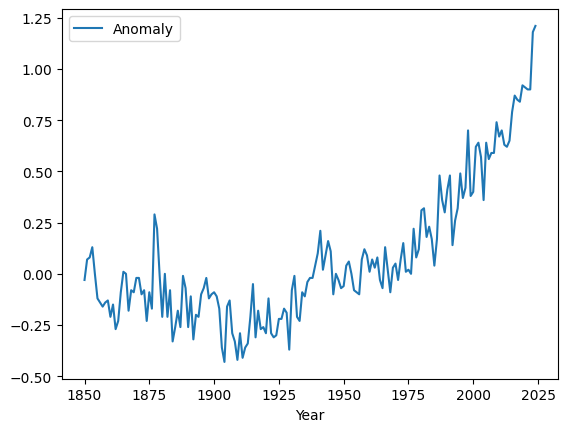

In [24]:
df.plot()

More plots ...

Boxplot:

/tmp/ipykernel_318/3456822592.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(decade_data, labels=df['Decade'].unique())


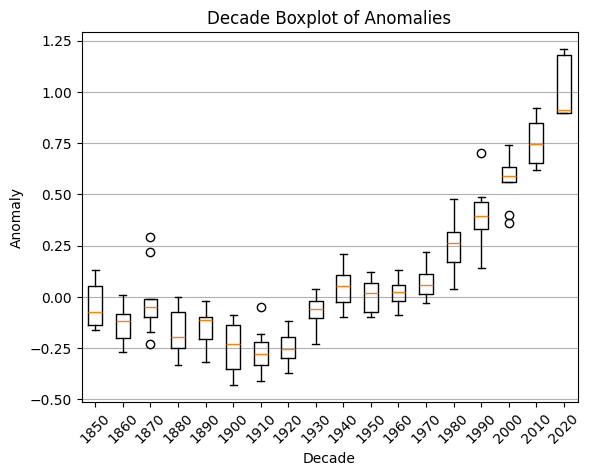

In [25]:
# Create a new column for decade
df['Decade'] = (df.index // 10) * 10

# Prepare data for boxplot
decade_data = [df[df['Decade'] == decade]['Anomaly'].values for decade in df['Decade'].unique()]

# Create boxplot using matplotlib
plt.figure()
plt.boxplot(decade_data, labels=df['Decade'].unique())
plt.title('Decade Boxplot of Anomalies')
plt.xlabel('Decade')
plt.ylabel('Anomaly')
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

Bar plot:

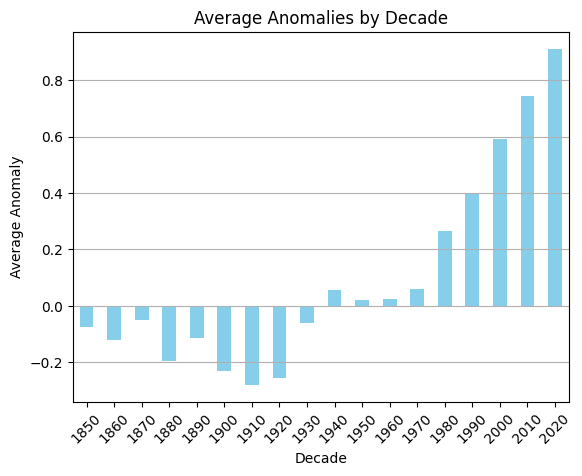

In [26]:
# Calculate the average anomaly per decade
average_anomalies = df.groupby('Decade')['Anomaly'].median()

# Create a bar plot using matplotlib
plt.figure()
average_anomalies.plot(kind='bar', color='skyblue')
plt.title('Average Anomalies by Decade')
plt.xlabel('Decade')
plt.ylabel('Average Anomaly')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## 3.2. xarray for netCDF

Like pandas for netCDF, it is a powerful library for handling and analyzing multi-dimensional arrays, commonly used for time series data.

Load a dataset from ERA5 reanalysis: 

If not unpacked already, the .7z file must be unpacked (use py7zr library).

In [27]:
with py7zr.SevenZipFile('../Datasets/ERA5_snippet.7z', mode='r', password='secret') as archive:
    archive.extractall(path='../Datasets/')

In [28]:
ERA5 = xr.open_dataset('../Datasets/ERA5_snippet.nc')

Investigate:

In [29]:
print(ERA5)

<xarray.Dataset> Size: 171MB
Dimensions:    (longitude: 37, latitude: 33, time: 8760)
Coordinates:
  * longitude  (longitude) float32 148B 6.0 6.25 6.5 6.75 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 132B 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * time       (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
Data variables:
    t2m        (time, latitude, longitude) float64 86MB ...
    tp         (time, latitude, longitude) float64 86MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-27 15:32:48 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


In [30]:
print(ERA5['tp'])

<xarray.DataArray 'tp' (time: 8760, latitude: 33, longitude: 37)> Size: 86MB
[10695960 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 148B 6.0 6.25 6.5 6.75 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 132B 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * time       (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
Attributes:
    units:      m
    long_name:  Total precipitation


In [31]:
print(ERA5['t2m'])

<xarray.DataArray 't2m' (time: 8760, latitude: 33, longitude: 37)> Size: 86MB
[10695960 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 148B 6.0 6.25 6.5 6.75 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 132B 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * time       (time) datetime64[ns] 70kB 2023-01-01 ... 2023-12-31T23:00:00
Attributes:
    units:      K
    long_name:  2 metre temperature


Mathematical operations:

In [32]:
ERA5['t2m'] = ERA5['t2m'] - 273.15 # convert K to °C
print(ERA5['t2m'])

<xarray.DataArray 't2m' (time: 8760, latitude: 33, longitude: 37)> Size: 86MB
array([[[10.54203654, 10.65896626, 10.68796484, ...,  8.53178063,
          8.60006759,  8.61784091],
        [11.02752877, 10.92837236, 10.8600854 , ...,  9.94803351,
          9.80491152,  9.7600105 ],
        [11.10610555, 11.00694914, 10.84044121, ..., 10.27824307,
         10.1603779 , 10.37739948],
        ...,
        [14.9320463 , 15.1397135 , 15.19958152, ..., -0.03870083,
          0.28776697,  0.65071685],
        [15.0704911 , 15.26038498, 14.34833309, ..., -0.48771099,
         -0.05834503,  0.2858961 ],
        [14.06115368, 13.31467428, 12.38952626, ...,  0.0707454 ,
          0.79945147,  1.24471988]],

       [[10.84324752, 11.01162633, 11.11639537, ...,  9.62624289,
          9.55982681,  9.45505777],
        [11.17345707, 11.13042693, 11.11920168, ..., 10.6524182 ,
         10.59161474, 10.50368358],
        [11.17532795, 11.13229781, 10.99759476, ..., 10.4176233 ,
         10.38020579, 10.

Resample:

In [33]:
ERA5 = ERA5.resample(time='1D').mean()  # Daily mean
print(ERA5)

<xarray.Dataset> Size: 7MB
Dimensions:    (time: 365, latitude: 33, longitude: 37)
Coordinates:
  * longitude  (longitude) float32 148B 6.0 6.25 6.5 6.75 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 132B 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
  * time       (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
Data variables:
    t2m        (time, latitude, longitude) float64 4MB 10.08 10.14 ... 0.6181
    tp         (time, latitude, longitude) float64 4MB 0.0001296 ... 7.401e-05
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-27 15:32:48 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


Select a specific date:

In [34]:
print(ERA5['t2m'][0,:,:]) # select by index
# or 
print(ERA5['t2m'].sel(time='2023-01-01')) # select by time component

<xarray.DataArray 't2m' (latitude: 33, longitude: 37)> Size: 10kB
array([[10.08039796, 10.14260458, 10.20052377, ...,  9.36357974,
         9.41771821,  9.46386648],
       [10.19740565, 10.16295035, 10.14151324, ...,  9.77388617,
         9.76320658,  9.78589095],
       [10.1424097 , 10.10760361,  9.95840128, ...,  9.28738054,
         9.29747547,  9.58028951],
       ...,
       [15.53057061, 15.40424753, 15.03256689, ...,  2.52576302,
         3.06640711,  3.52145864],
       [15.81034448, 15.61168087, 14.3003919 , ...,  1.64419081,
         2.35668263,  2.81820427],
       [14.81620792, 13.61888646, 12.29286435, ...,  2.52630869,
         2.93836906,  3.44650669]])
Coordinates:
  * longitude  (longitude) float32 148B 6.0 6.25 6.5 6.75 ... 14.5 14.75 15.0
  * latitude   (latitude) float32 132B 55.0 54.75 54.5 54.25 ... 47.5 47.25 47.0
    time       datetime64[ns] 8B 2023-01-01
<xarray.DataArray 't2m' (latitude: 33, longitude: 37)> Size: 10kB
array([[10.08039796, 10.14260458, 10.20

Plot with `matplotlib`:

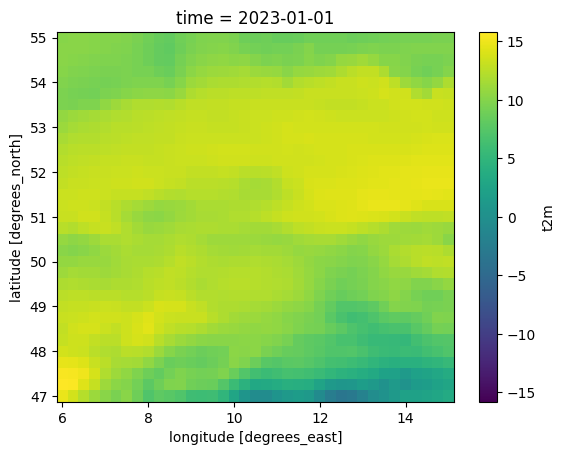

In [35]:
ERA5['t2m'][0,:,:].plot(cmap='viridis')

Plot with `cartopy` & `matplotlib`:

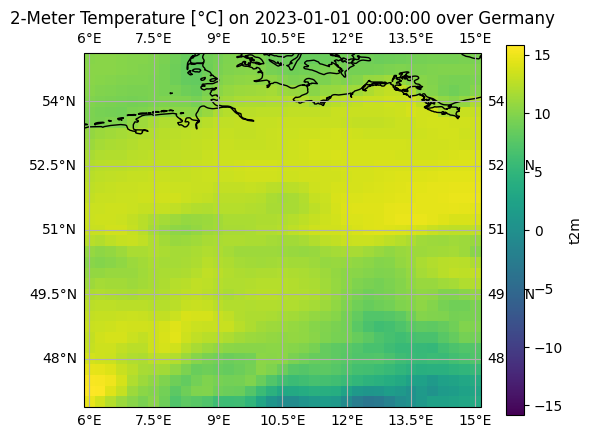

In [36]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())

# Use the plot method for quick visualization
ERA5['t2m'][0,:,:].plot(ax=ax, cmap='viridis', add_colorbar=True)

# Add coastlines and grid lines
ax.coastlines()
ax.gridlines(draw_labels=True)

plt.title('2-Meter Temperature [°C] on 2023-01-01 00:00:00 over Germany')
plt.show()

### Extracting 1D time series from a single grid cell:

Select data for Bremen:

In [37]:
bremen = ERA5.sel(longitude=8.808, latitude=53.075, method='nearest')
print(bremen)

<xarray.Dataset> Size: 9kB
Dimensions:    (time: 365)
Coordinates:
    longitude  float32 4B 8.75
    latitude   float32 4B 53.0
  * time       (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
Data variables:
    t2m        (time) float64 3kB 13.04 10.03 5.596 9.893 ... 8.626 6.874 7.885
    tp         (time) float64 3kB 0.0001076 0.0002407 ... 3.678e-05 8.547e-05
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-27 15:32:48 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


Plot:

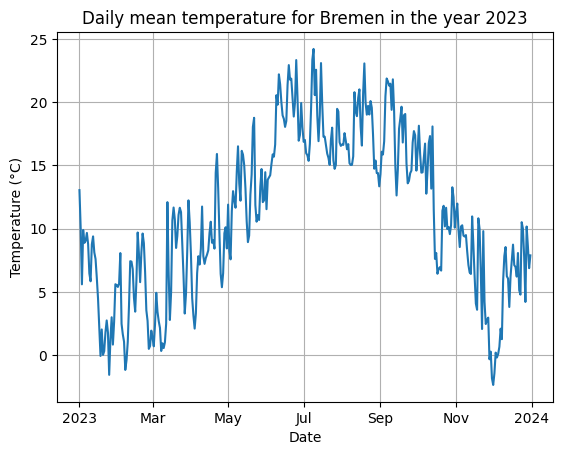

In [38]:
bremen['t2m'].plot()
plt.title('Daily mean temperature for Bremen in the year 2023')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.grid()
plt.show()

**Exercise:** Select and plot the temperature time series for another region of your choice in Germany.

In [39]:
berlin = ERA5.sel(longitude=13.405, latitude=52.520, method='nearest')
print(berlin)

<xarray.Dataset> Size: 9kB
Dimensions:    (time: 365)
Coordinates:
    longitude  float32 4B 13.5
    latitude   float32 4B 52.5
  * time       (time) datetime64[ns] 3kB 2023-01-01 2023-01-02 ... 2023-12-31
Data variables:
    t2m        (time) float64 3kB 13.86 12.28 5.216 6.781 ... 8.911 6.07 5.33
    tp         (time) float64 3kB 1.445e-05 9.095e-05 ... 0.000141 3.254e-05
Attributes:
    Conventions:  CF-1.6
    history:      2024-08-27 15:32:48 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


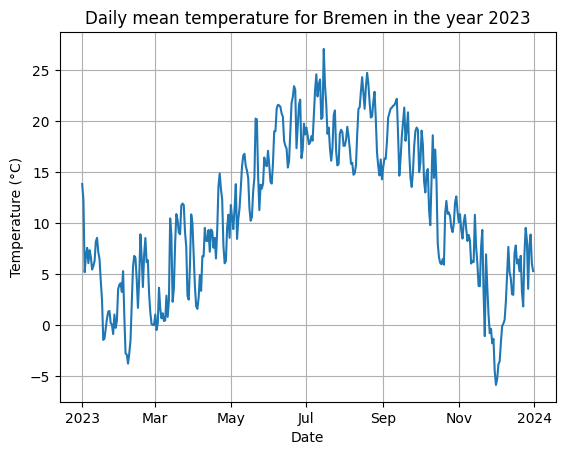

In [40]:
berlin['t2m'].plot()
plt.title('Daily mean temperature for Bremen in the year 2023')
plt.ylabel('Temperature (°C)')
plt.xlabel('Date')
plt.grid()
plt.show()